In [151]:
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator

TelescopeParameter type argument 'LST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


ImageExtractor
False
5813.8194279014


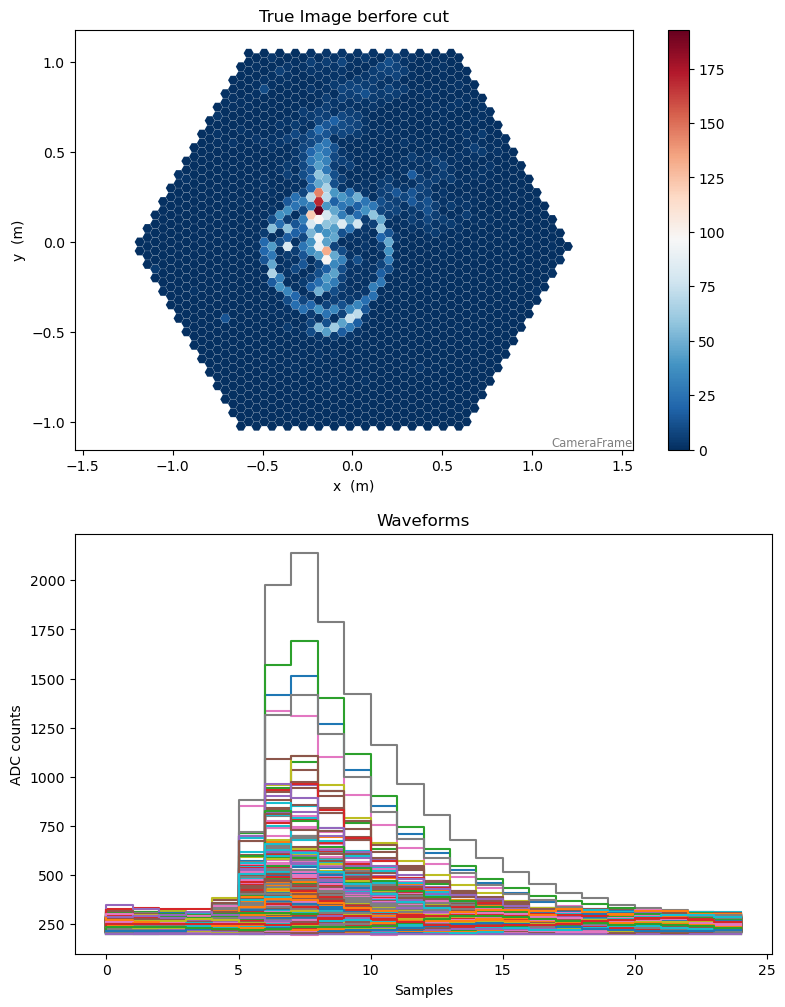

In [156]:
filename = '/Users/vdk/MST_work/data_muons/mono_proton_simtel/proton_20deg_0deg_run2___cta-prod6-paranal-2147m-Paranal-nshow-3000-0-LSTs-1-MSTs-0-SSTs-NSCAT_5_CSCAT_300_EMIN_1_EMAX_200_after_muontag.simtel.zst'
#filename = '/Users/vdk/MST_work/data_muons/mono_muon_simtel/muon_20deg_0deg_run0___cta-prod6-paranal-2147m-Paranal-0-LSTs-1-MSTs-0-SSTs-NSCAT_1_CSCAT_8_EMIN_0.005_EMAX_1_FIXCHI_600_VIEWCONE_3_after_muontag.simtel.zst'
source = EventSource(filename, max_events=9000)
event_iterator = iter(source)



for i,j in enumerate(event_iterator):
    if i == 4:
        event3 = j
        image_processor = ImageProcessor(source.subarray)
        muon_processor = MuonProcessor(source.subarray)
        calib = CameraCalibrator(
                image_extractor_type="NeighborPeakWindowSum",
                subarray = source.subarray)
        calib(j)
        image_processor(j)
        muon_processor(j)
        fig, axes = plt.subplots(2, 1, sharex=False, gridspec_kw={'height_ratios': [1, 1]}, figsize=(9,12))
        fig.subplots_adjust(hspace=0.2)
        ax = axes[0]
        camgeom = source.subarray.tel[1].camera.geometry
        #title="TrueImage run {} if {} fit {} width {}".format(j.index.obs_id, j.index.event_id, round(j.muon.tel[1].efficiency.optical_efficiency, 3), round(j.muon.tel[1].efficiency.width.to_value(),3))
        title = "True Image berfore cut"
        disp = CameraDisplay(camgeom,title=title, ax = ax)
        disp.image = j.simulation.tel[1].true_image #.sum(axis=1)
        disp.cmap = plt.cm.RdBu_r
        disp.add_colorbar()
        disp.set_limits_percent(95)
        bx = axes[1]
        for pix_id in range(0,1764):
            bx.plot(j.r0.tel[1].waveform[0][pix_id], label="pix {}".format(pix_id), drawstyle='steps')
        bx.set_ylabel("ADC counts")
        bx.set_xlabel("Samples")
        bx.set_title("Waveforms")
        plt.show()
        #plt.savefig("/Users/vdk/TrueImageBeforeCut")
        #plt.savefig(f"/Users/vdk/MST_ProtonImages_NewQualityCheck/TrueImage+Waveform_mstPROTON_event{j.index.event_id}_obs{j.index.obs_id}_numer{i}")
        #plt.savefig(f"/Users/vdk/TrueImage+Waveform_mstMUON_event{j.index.event_id}_obs{j.index.obs_id}")
        break
        #if i == 150:
        #    break

plt.close()

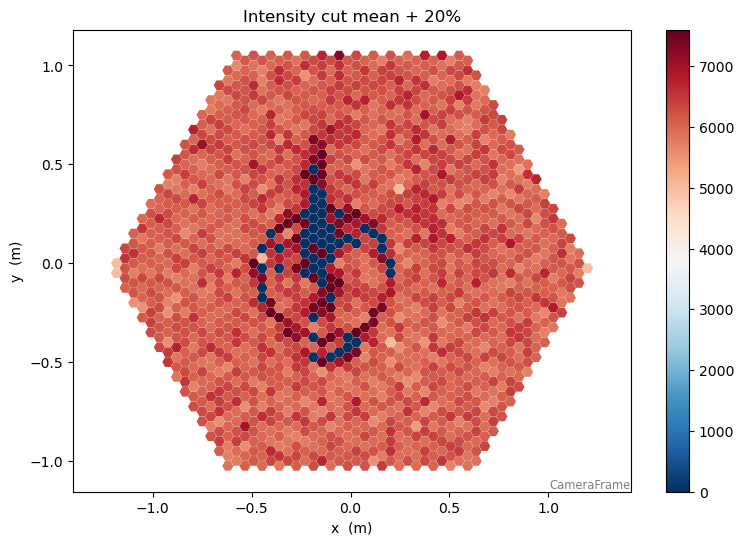

In [178]:
# check only pixels where signal is less then some value
# mean value for all pixels sum over the samples is 6200

condition = 8000
work_arr = event3.r0.tel[1].waveform[0].copy()
work_arr[np.sum(work_arr, axis = 1) > condition] = 0
new_index = []
new_image = []

blanc = [250 for i in range(25)]
for i,j in enumerate(event3.r0.tel[1].waveform[0]):
    if sum(j) < condition:
        new_index.append(i)
        new_image.append(work_arr[i])
        #plt.plot(event3.r0.tel[1].waveform[0][i], label="pix {}".format(pix_id), drawstyle='steps')
    else:
        new_image.append(work_arr[i])
        #plt.plot(work_arr[i], label="pix {}".format(pix_id), drawstyle='steps')
        #print()
        
new_image = np.array(new_image)

plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Intensity cut mean + 20%"
disp = CameraDisplay(camgeom,title=title)
disp.image = new_image.sum(axis=1)
#disp.image = true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
#plt.savefig(f"/Users/vdk/TrueImageIntencityCutMean+20%")

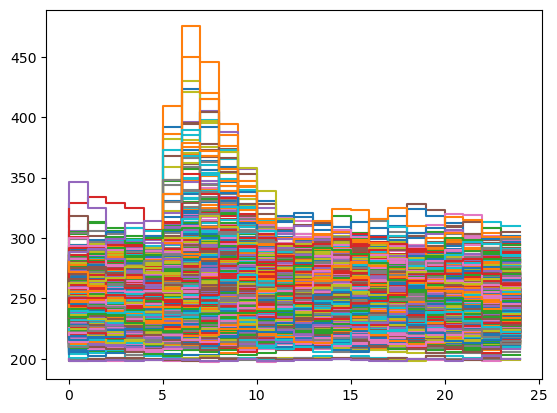

In [84]:
for pix_id in range(0,1764):
    plt.plot(work_arr[pix_id], label="pix {}".format(pix_id), drawstyle='steps')

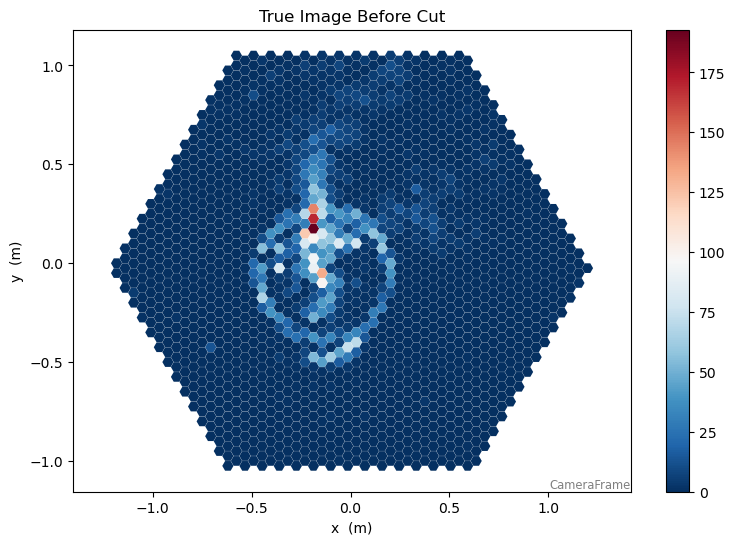

In [158]:
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="True Image Before Cut"
disp = CameraDisplay(camgeom,title=title)
disp.image = work_arr.sum(axis=1)
#disp.image = true_image
disp.image = event3.simulation.tel[1].true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)
plt.savefig("/Users/vdk/TrueImageBeforeCut")

In [28]:
print(min(np.sum(work_arr, axis = 1)))
print(max(np.sum(work_arr, axis = 1)))
print(np.mean(np.sum(work_arr, axis = 1)))
print(np.std(np.sum(work_arr, axis = 1)))

4976
6500
6113.331632653061
215.2662578958693


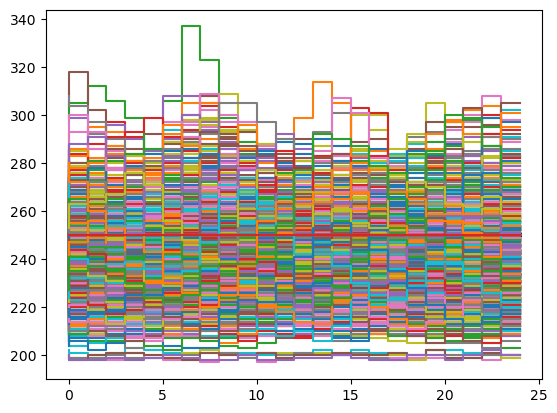

In [72]:
new_index = []
new_image = []
blanc = [250 for i in range(25)]
condition = 6300
for i,j in enumerate(event3.r0.tel[1].waveform[0]):
    if sum(j) < condition:
        #print(i,sum(j))
        new_index.append(i)
        new_image.append(event3.r0.tel[1].waveform[0][i])
        plt.plot(event3.r0.tel[1].waveform[0][i], label="pix {}".format(pix_id), drawstyle='steps')
    else:
        new_image.append(blanc)
        plt.plot(blanc, label="pix {}".format(pix_id), drawstyle='steps')
        
new_image = np.array(new_image)

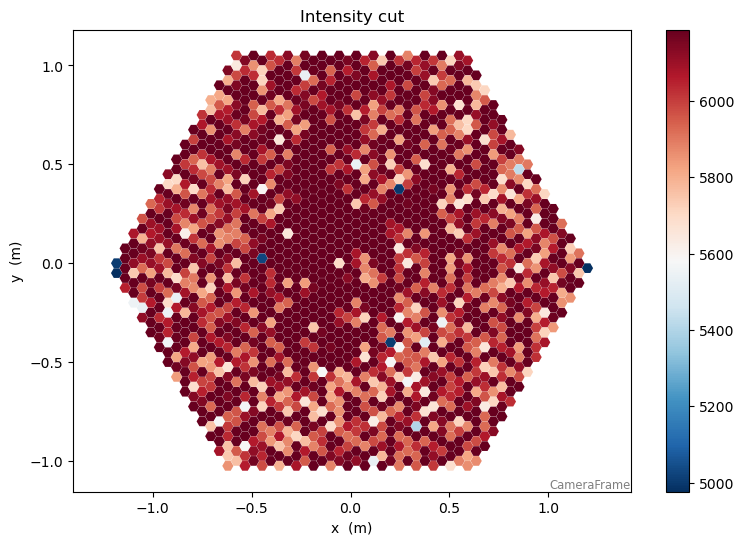

In [71]:
plt.figure(figsize = (9,6))
camgeom = source.subarray.tel[1].camera.geometry
title="Intensity cut"
disp = CameraDisplay(camgeom,title=title)
#disp.image = new_image.sum(axis=1)
disp.image = true_image
disp.cmap = plt.cm.RdBu_r
disp.add_colorbar()
disp.set_limits_percent(95)

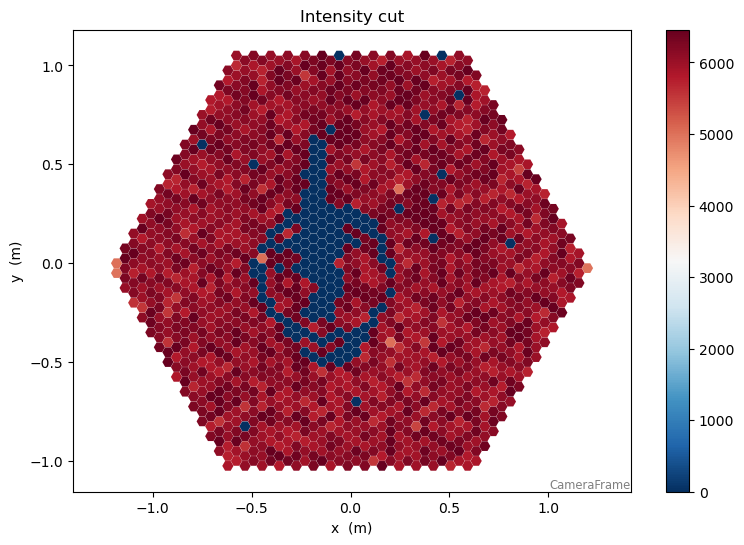

In [44]:
new_image

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [235, 247, 256, ..., 251, 247, 234],
       [241, 235, 237, ..., 248, 240, 232],
       [246, 250, 250, ..., 283, 270, 262]])